# K Nearest Neighbors

### 1 - Define the node of Kd tree

In [36]:
class Kd_node():
    
    
    # Define the node of Kd tree
    def __init__(self, data=None, label=None, split=None, left=None, right=None):
        """
        Initialize the parameters of node
        
        Arguments:
        data -- feature vector of the input instance
        label -- label of the input instance
        split -- the spliting dimension
        left -- left child node 
        right -- right child node
        
        """
        self.data = data
        self.label = label
        self.split = split
        self.left = left
        self.right = right
        
        return None
    

### 2 - Define KNN Classifier
- Note: must transfer X_train to ndarray，and encode Y_train into np.float.

In [1]:
import numpy as np

class KNeighborsClassifier():
    
    
    def __init__(self, k_neighbors=3):
        # Define the num of k-nearest neighbors
        self.k_neighbors = k_neighbors
        return
    
    
    def generate_KdTree(self, data_list, label_list):
        """
        Generate the Kd tree by recursion method
        
        Arguments:
        data_list -- a series of data points in feature space
        label_list -- the corresponding labels of feature vectors
        
        Return:
        root -- the root of generated Kd tree
        
        """
        # Recursion: Base line, split end when there is no point in subspcae
        if len(data_list) == 0:
            return None
        
        # Extract length and num of dimension of training data 
        num_data = data_list.shape[0]       
        dim_data = data_list.shape[1] 
        
        # Initialize max variance and splitting dimension
        max_var = 0
        split = 0
        # Find the split dimension which has the max variance
        for i in range(dim_data):
            col_i = data_list[:, i]
            var = np.var(col_i)
            if var > max_var:
                max_var = var
                split = i      
                
        # Sort data_list and label_list along the splitted dimension
        indexs = np.argsort([v[i] for v in data_list])
        data_list = data_list[indexs]
        label_list = label_list[indexs]
        
        # Choose the median of list as splitting point
        data = data_list[int(num_data/2)]
        label = label_list[int(num_data/2)]
        # Generate current Kd node
        root = Kd_node(data, label, split)
        
        # Recursion Call: generate left and right child node of current node
        root.left = self.generate_KdTree(
            data_list[0:int(num_data/2)], label_list[0:int(num_data/2)])
        root.right = self.generate_KdTree(
            data_list[int(num_data/2)+1 : num_data], label_list[int(num_data/2)+1 : num_data])
        
        # Return the root of this Kd tree
        return root
    
    
    def fit(self, X_train, Y_train):
        """
        Fit training data
        
        Arguments:
        X_train -- input training dataset,  shape = [n_samples, n_features]
        Y_train -- labels of training data, shape = [n_samples]
 
        """
        # Generate Kd tree and get the root of it
        self.root = self.generate_KdTree(data_list=X_train, label_list=Y_train)
        
        return None
    
    
    def predict(self, query):
        """
        predict the corresponding label of query point
        
        Argument:
         query -- data point waiting for classifying
        
        Return:
        label -- the result of prediction
        
        """
        knn = self.find_knn(query)
        label = self.vote(knn)
        
        return label
    
    
    def find_knn(self, query):
        """
        Find the k-nearest node in Kd tree
        
        Argument:
        query: data point waiting for classifying
        
        Return:
        knn -- the list of nodes which are k-nearest for query point
        
        """
        # Initialize a list for storing searching path
        node_list = []
        # initialize a list for storing k-nearest nodes
        knn = []
        # set root of Kd tree as current node
        temp_root = self.root
        
        # Use binary search to create the searching path 
        while temp_root:
            # add this point into searching path
            node_list.append(temp_root)
            # Judge and update the list fo k-nearest nodes
            if len(knn) < self.k_neighbors:
                knn.append(temp_root)
            else:
                knn = self.update_knn_list(knn, temp_root, query)
            # Decide the next searching direction by splitted  dimension
            split_dim = temp_root.split
            if query[split_dim] < temp_root.data[split_dim]:
                temp_root = temp_root.left
            else:
                temp_root = temp_root.right
      
        # Back track along the searched path
        while node_list:
            # Simulate stack by list: last-in and first-out
            last_node = node_list.pop()
            last_split = last_node.split
            # Whether need to go into the other subspace  of parent node
            temp_max_dist = self.max_dist(knn, query)
            if abs(query[last_split] - last_node.data[last_split]) < temp_max_dist:
                # Set the direction of subspace for searching
                if query[last_split] <= last_node.data[last_split]:
                    temp_root = last_node.right
                else:
                    temp_root = last_node.left 
                # Whether subspace exists
                if temp_root:
                    node_list.append(temp_root)
                    # Update the knn list
                    if len(knn) < self.k_neighbors:
                        knn.append(temp_root)
                    else:
                        knn = self.update_knn_list(knn, temp_root, query)
                        
        return knn
    
    
    def vote(self, knn):
        """
        Vote that choose the label which appear most frequently in k-nearest nodes
        
        Argument:
        knn_list --  node list of k-nearest neighbors
        
        Return:
        label -- the label which appear most frequently in knn list
        
        """
        # Set a dict and its key represnts the label and value represents the frequency of appearance
        d = {}
        # Count frequency of each label
        for node in knn:
            if node.label in d:
                d[node.label] += 1
            else:
                d[node.label] = 1
        # Get the label which appear most frequently in knn list   
        label = max(d, key=d.get)
        
        return label
    
    
    def update_knn_list(self, knn_list, temp_node, query):
        """
        Judge and update k-nearest neighbors
        
        Arguments:
        knn_list -- current node list of k-nearest neighbors
        temp_node -- temporary node 
        query -- data point waiting for classifying
        
        Return:
        knn -- the list of nodes which are k-nearest for query point
        
        """
        # Get the distance between temp_node and query
        current_dist = self.compute_dist(temp_node.data, query)
        # Get k-neares nodes
        knn = knn_list
        # set max distance as zero
        temp_max_dist = 0
        
        # Calculate the max distance in current knn nodes
        for i in range(len(knn_list)):
            feature_vector = knn_list[i].data
            dist = self.compute_dist(feature_vector, query)
            if dist > temp_max_dist:
                temp_max_dist = dist
                index_del = i
                
        # Whether need to replace a node in previous knn list 
        if current_dist < temp_max_dist:
            del knn[index_del]
            knn_list.append(temp_node)
            
        # Return the list of knn nodes after updating
        return knn 
    
    def compute_dist(self, v1, v2):
        """
        Calculate the Euclidean distance between vector_1 and vector_2
        
        Arguments:
        v1 -- the 1st input vector 
        v2 -- the 2nd input vector
        
        Return:
        Euclidean distance between v1 and v2
        
        """
        return np.linalg.norm(v1-v2)
    
    
    def max_dist(self, knn_list, query):
        """
        Calculate the max distance between knn list and query point
        
        Arguments:
        knn_list -- current node list of k-nearest neighbors
        query -- data point waiting for classifying
        
        Return:
        max_value -- the max distance 
        
        """
        max_value = 0
        for i in range(len(knn_list)):
            dist = self.compute_dist(knn_list[i].data, query)
            if dist > max_value:
                max_value = dist
                
        return max_value
    

### Test

In [37]:
from matplotlib import pyplot as plt

%matplotlib inline

#### generate artificial samples

In [62]:
x = np.array([[3,3], [4,3], [1,2.5], [0.5,0.5], [2,2], [1,5], [2.5,1.5], [3.5,2.5], [1.5,3], [1.5,2],
              [1.0,4.5],[2,4.5], [3,4.5],[0.7,3.7], [3,2]])
y = np.array([1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1,-1, -1 ])

#### training model

In [63]:
model = KNeighborsClassifier(3)
model.fit(x,y)

#### visualizing
- 蓝色点为待查询点，其最邻近的三个值有两个'+1'，一个'-1'，因此分类结果输出'+1'

Prediction:  1


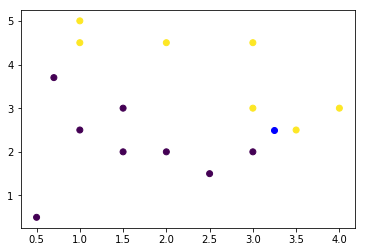

In [64]:
fig_1 = plt.scatter(x[:,0], x[:,1], c=y)
query = np.array([3.25, 2.5])
fig_1 = plt.scatter(query[0], query[1], c='blue')
print('Prediction: ', model.predict(query))